# HW 1 Starter Code (TODO RENAME as HW1 FirstName LastName)

For the original HW1 Instructions see:

https://www.cs.tufts.edu/cs/152BDL/2022f/hw1.html

# Collaboration statement

> At the top of your writeup, you must include the names of any people you worked with, and in what way you worked them (discussed ideas, debugged math, team coding). We may occasionally check in with groups to ascertain that everyone in the group was participating in accordance with this policy.

TODO FILL WITH YOUR COLLAB STATEMENT

I worked with fellow students ABC and XYZ on _____.

I also talked to DEF about ____.

I talked to the TA in office hours on Friday too.

Thanks to Wikipedia about the definition of `Bessel_function` and `Matern kernel`

Thanks to Question @23 on Piazza


# Imports

In [68]:
import numpy as np
import pandas as pd

import scipy.stats
from scipy.stats import multivariate_normal
from scipy.special import kv
from scipy.special import gamma

In [69]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns

sns.set('notebook', font_scale=1.5, style='whitegrid')

# Problem 1: Sample from GP prior

## Write code to sample f values from prior

In [70]:
def draw_sample_of_f_from_GP_prior_at_x_grid(
        x_grid_G, mean_func, cov_func,
        kernel_kwargs={},
        random_seed=42,
        n_samples=1):
    """ Draw sample from GP prior given mean/cov functions

    Args
    ----
    x_grid_G : 1D array, size n_grid_pts (G)
        Contains G specific x_i values to evaluate function at
    mean_func : function, maps (1D arr size A) to (1D arr size A)
        Computes mean value $m(x_i)$ at each input x_i value
    cov_func : function, maps (1D arr size A, 1D arr size B) to (2D AxB)
        Computes covariance (kernel) value at each pair of inputs.
    kernel_kwargs : dict
        Each key,val pair provides the name and float value of
        the named hyperparameter for kernel function
    random_seed : int
        See for the random number generator
    n_samples : int
        Number of samples to draw from the prior

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    S = int(n_samples)
    G = x_grid_G.size
    mean_G = mean_func(x_grid_G)
    cov_GG = cov_func(x_grid_G, **kernel_kwargs)
    assert cov_GG.shape == (G, G)

    # Use consistent random number generator for reproducibility
    prng = np.random.RandomState(int(random_seed))
    # f_SG = np.arange(S).reshape((S,1)) * np.ones((S, G))
    # TODO FIX use prng.multivariate_normal(...)
    # multivariate_normal(mean, cov, size=None, check_valid='warn', tol=1e-8)
    f_SG = prng.multivariate_normal(mean_G, cov_GG, size=(S,))
    return f_SG

In [71]:
def plot_f_samples_at_x_grid(x_grid_G, f_grid_SG,
                             color=None, axis_handle=None):
    if axis_handle is None:
        axis_handle = pylab.gca()  # get current axis handle if not provided
    S, G = f_grid_SG.shape
    for s in range(S):
        axis_handle.plot(x_grid_G, f_grid_SG[s], '-', color=color)

### Define mean_func

In [72]:
def mean_func(x_grid_G):
    return np.zeros_like(x_grid_G)

### Define sqexp kernel

In [73]:
def sqexp_kernel_func(x_grid_A, x_grid_B=None, **kernel_kwargs):
    ''' Compute squared exponential kernel between two provided arrays

    Args
    ----
    x_A : 1D array, shape (A,)
        Contains univariate x value for each of A observations
    x_B : 1D array, shape (B,)
        Contains univariate x value for each of B observations
    kernel_kwargs : dict
        Contains length scale value under key 'L'

    Returns
    -------
    k_AB : 2D array, shape (A,B)
        Kernel matrix where k_AB[aa, bb]
        gives the kernel value between x_grid_A[aa], x_grid_B[bb]
    '''
    # Handy code to reshape provided 1D arrays into 2D for efficient vector ops
    if x_grid_B is None:
        x_grid_B = x_grid_A.copy()
    A = x_grid_A.shape[0]
    B = x_grid_B.shape[0]
    xa_A1 = np.reshape(x_grid_A, (A, 1))
    xb_1B = np.reshape(x_grid_B, (1, B))

    # Pull desired lengthscale value out of dict
    L = kernel_kwargs['L']

    # TODO fixme
    return np.exp((xa_A1 - xb_1B) ** 2 / (-0.5 * L ** 2))

### Define Matern kernel

In [74]:
def matern_kernel_func(x_grid_A, x_grid_B=None, **kernel_kwargs):
    ''' Compute Matern kernel between two provided arrays

    Args
    ----
    x_A : 1D array, shape (A,)
        Contains univariate x value for each of A observations
    x_B : 1D array, shape (B,)
        Contains univariate x value for each of B observations
    kernel_kwargs : dict
        Contains length scale value under key 'L'
        Contains smoothness value under key 'nu'

    Returns
    -------
    k_AB : 2D array, shape (A,B)
        Kernel matrix where k_AB[aa, bb]
        gives the kernel value between x_grid_A[aa], x_grid_B[bb]
    '''
    # Handy code to reshape provided 1D arrays into 2D for efficient vector ops
    if x_grid_B is None:
        x_grid_B = x_grid_A.copy()
    A = x_grid_A.shape[0]
    B = x_grid_B.shape[0]
    xa_A1 = np.reshape(x_grid_A, (A, 1))
    xb_1B = np.reshape(x_grid_B, (1, B))

    # Pull desired lengthscale value out of dict
    L = kernel_kwargs['L']
    v = kernel_kwargs['nu']

    distance = np.fabs(xa_A1 - xb_1B)
    distance[distance == 0] += 1e-15

    return 2 ** (1 - v) / gamma(v) * \
           (((2 * v) ** 0.5) * distance / L) ** v * \
           kv(v, (2 * v) ** 0.5 / L * distance)

### Setup plot appearance properties

In [75]:
H = 4  # Panel height
W = 6  # Panel width

S = 3  # num samples to draw from posterior

G = 501  # num grid points to use
x_grid_G = np.linspace(-6, 6, G)

## Part a: Plots of samples with Squared Exponential Kernel

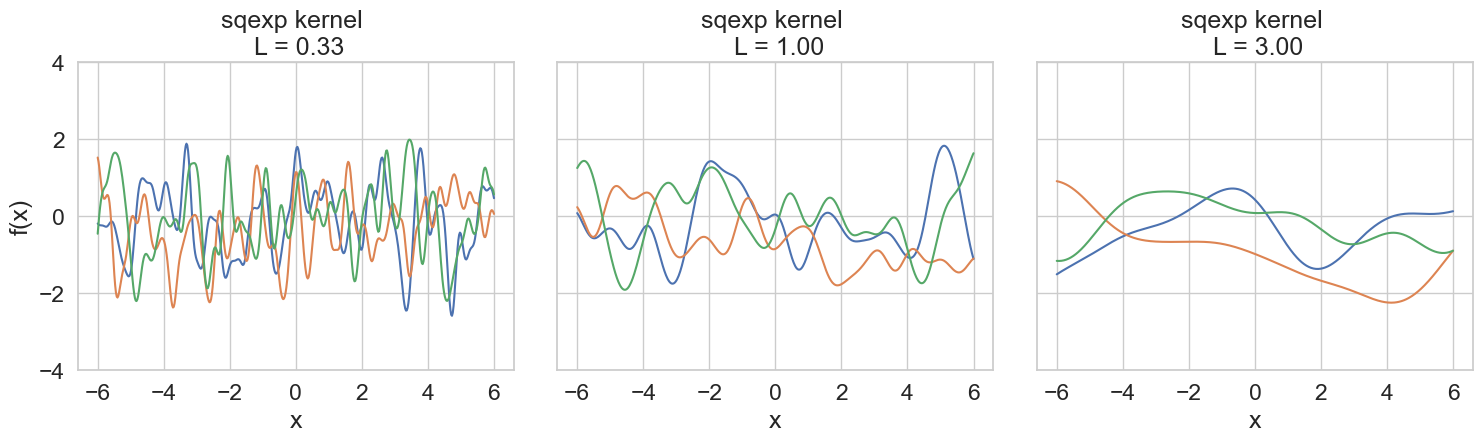

In [76]:
ell_list = [0.33, 1.0, 3.0]
ncols = len(ell_list)
nrows = 1

fig_h, axes_list = plt.subplots(
    nrows=nrows, ncols=ncols,
    sharex=True, sharey=True,
    figsize=(W * ncols, H * nrows))
for ii, L in enumerate(ell_list):
    cur_ax_h = axes_list[ii]

    f_grid_SG = draw_sample_of_f_from_GP_prior_at_x_grid(
        x_grid_G, mean_func, sqexp_kernel_func,
        kernel_kwargs=dict(L=L), n_samples=S)
    assert f_grid_SG.shape == (S, G)

    plot_f_samples_at_x_grid(
        x_grid_G,
        f_grid_SG,
        axis_handle=cur_ax_h,
    )
    cur_ax_h.set_title('sqexp kernel \n L = %.2f' % L)
    cur_ax_h.set_yticks([-4, -2, 0, 2, 4]);
    cur_ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
    cur_ax_h.set_xlabel('x');
    if ii == 0: cur_ax_h.set_ylabel('f(x)');

plt.subplots_adjust(hspace=0, wspace=0.1)

## Part 1b: Short answer interpreting SqExp Plots

As the formula $exp(−\frac{(x−x′)^2}{2L^2})$ states, the hyperparameter $L$ determines the scale of the values distributed in y-axis. The larger is the given $L$ , the scale is smaller.

## Part 1c: Plots of samples with Matern Kernel

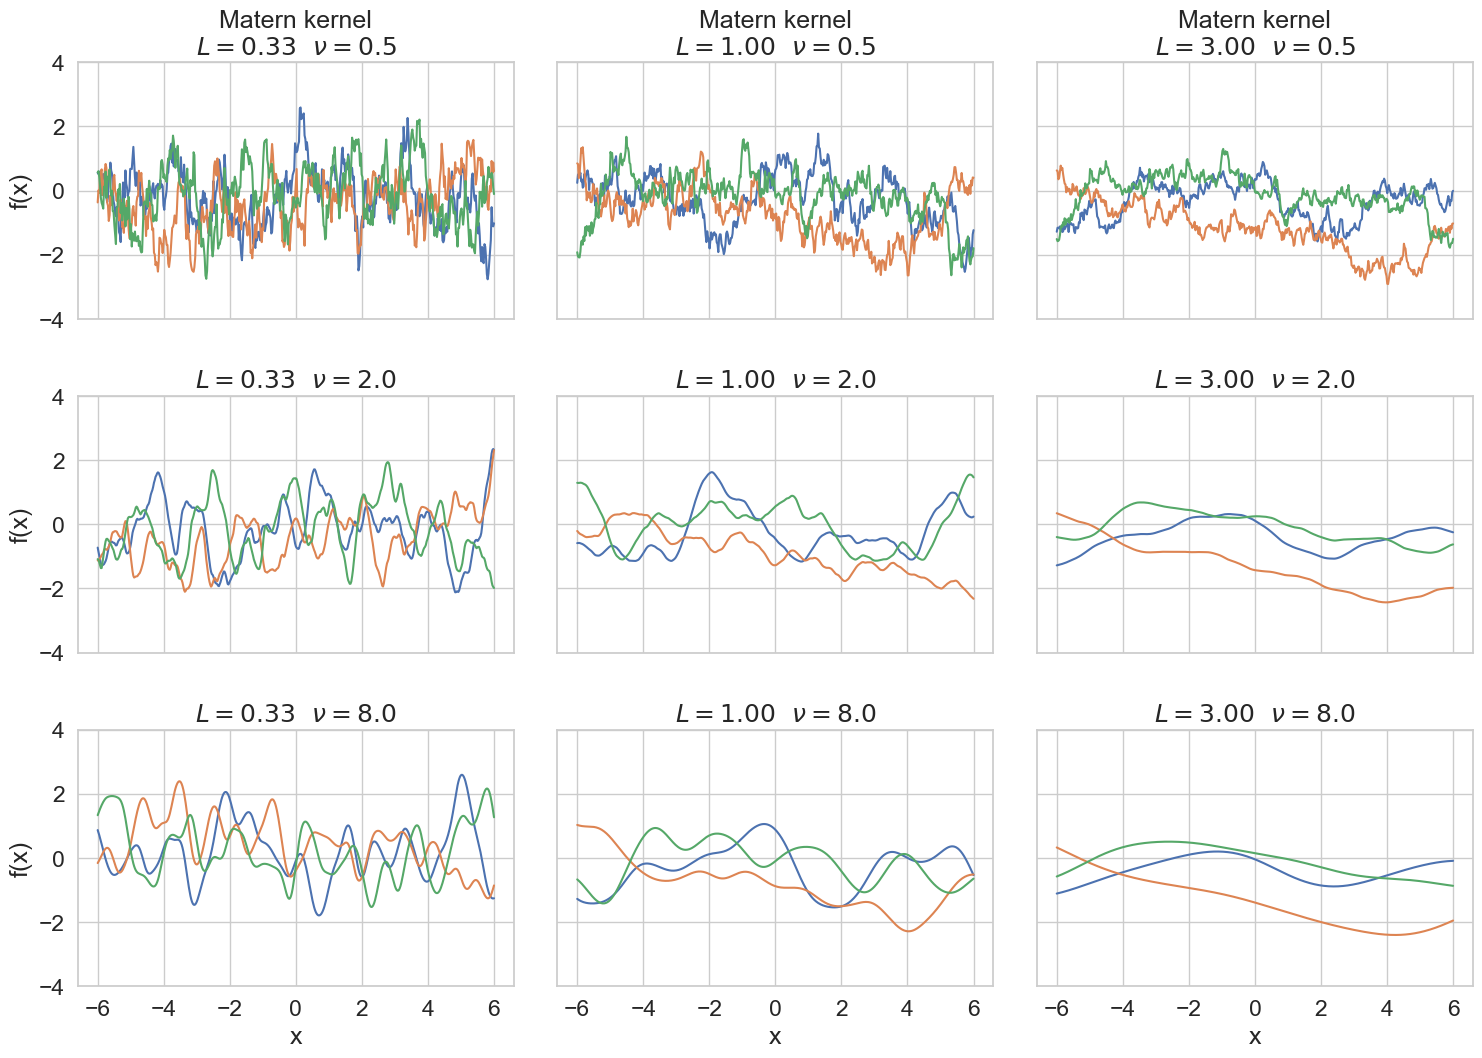

In [77]:
def draw_sample_of_f_from_GP_prior_at_x_grid(
        x_grid_G, mean_func, cov_func,
        kernel_kwargs={},
        random_seed=42,
        n_samples=1):
    """ Draw sample from GP prior given mean/cov functions

    Args
    ----
    x_grid_G : 1D array, size n_grid_pts (G)
        Contains G specific x_i values to evaluate function at
    mean_func : function, maps (1D arr size A) to (1D arr size A)
        Computes mean value $m(x_i)$ at each input x_i value
    cov_func : function, maps (1D arr size A, 1D arr size B) to (2D AxB)
        Computes covariance (kernel) value at each pair of inputs.
    kernel_kwargs : dict
        Each key,val pair provides the name and float value of
        the named hyperparameter for kernel function
    random_seed : int
        See for the random number generator
    n_samples : int
        Number of samples to draw from the prior

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    S = int(n_samples)
    G = x_grid_G.size
    mean_G = mean_func(x_grid_G)
    cov_GG = cov_func(x_grid_G, **kernel_kwargs)
    assert cov_GG.shape == (G, G)

    # Use consistent random number generator for reproducibility
    prng = np.random.RandomState(int(random_seed))
    # f_SG = np.arange(S).reshape((S,1)) * np.ones((S, G))
    # TODO FIX use prng.multivariate_normal(...)
    # multivariate_normal(mean, cov, size=None, check_valid='warn', tol=1e-8)
    f_SG = prng.multivariate_normal(mean_G, cov_GG, size=(S,))
    return f_SG


ell_list = [0.33, 1.0, 3.0]
ncols = len(ell_list)

nu_list = [0.5, 2.0, 8.0]
nrows = len(nu_list)

fig_h, axes_grid_RC = plt.subplots(
    nrows=nrows, ncols=ncols,
    sharex=True, sharey=True,
    figsize=(W * ncols, H * nrows))
for cc, L in enumerate(ell_list):
    for rr, nu in enumerate(nu_list):
        cur_ax_h = axes_grid_RC[rr, cc]

        f_grid_SG = draw_sample_of_f_from_GP_prior_at_x_grid(
            x_grid_G, mean_func, matern_kernel_func,
            kernel_kwargs=dict(L=L, nu=nu),
            n_samples=S)
        assert f_grid_SG.shape == (S, G)

        plot_f_samples_at_x_grid(
            x_grid_G,
            f_grid_SG,
            axis_handle=cur_ax_h
        )

        # Make plot look pretty. Please don't edit without good reasons.
        title_str = r'$L{=}%.2f~~\nu{=}%.1f$' % (L, nu)
        if rr == 0:
            title_str = 'Matern kernel\n' + title_str
        cur_ax_h.set_title(title_str)
        cur_ax_h.set_yticks([-4, -2, 0, 2, 4]);
        cur_ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
        if rr == len(nu_list) - 1: cur_ax_h.set_xlabel('x');
        if cc == 0: cur_ax_h.set_ylabel('f(x)');

plt.subplots_adjust(hspace=0.3, wspace=0.1)

## Part 1d: Short answer interpreting Matern plots

$L$ determins the range of $f(x)$. The larger is the $L$, the smaller the range is(i.e. the less heavily the line waves).

$ν$ determines the frequncy of how the line fluctuates.
The larger the $ν$ is, the less frequently the line waves).

# Problem 2: Sampling from GP posterior given data

## Implementing the posterior

In [78]:
def calc_posterior_params__mean_G_and_cov_GG(
        x_train_N,
        y_train_N,
        x_test_G,
        mean_func=None,
        cov_func=None,
        sigma=0.1,
        **kernel_kwargs):
    """ Compute parameters of Gaussian posterior over function value at G provided inputs
    
    Args
    ----
    x_train_N : 1D array, size n_train_pts (N)
    y_train_N : 1D array, size n_train_pts (N)
    x_grid_G : 1D array, size n_grid_pts (G)
    
    Returns
    -------
    mean_G : 1D array, size G
        Posterior mean vector
    cov_GG : 2D array, size G x G
        Posterior covariance matrix
    
    References
    ----------
    Alg. 2.1 of GPML book by Rasmussen and Williams
    http://www.gaussianprocess.org/gpml/chapters/RW2.pdf#page=13
    """
    N = x_train_N.shape[0]
    G = x_test_G.shape[0]

    mean_G = mean_func(x_grid_G)  # TODO fixme
    cov_GG = cov_func(x_grid_G,**kernel_kwargs)  # TODO fixme

    return mean_G, cov_GG

In [79]:
def draw_sample_of_f_from_GP_posterior_at_x_grid(
        x_train_N, y_train_N,
        x_grid_G, mean_func, cov_func,
        kernel_kwargs={},
        sigma=0.1,
        random_seed=42,
        n_samples=1):
    """ Draw sample from GP posterior given data and mean/cov functions

    Args
    ----
    x_train_N : 1D array, size n_train_pts (N)
        Contains observed inputs of each of the N training points
    y_train_N : 1D array, size n_train_pts (N)
        Contains observed outputs of each of the N training points
    x_grid_G : 1D array, size n_grid_pts (G)
        Contains G specific x_i values to evaluate function at
    mean_func : function, maps (1D arr size A) to (1D arr size A)
        Computes mean value $m(x_i)$ at each input x_i value 
    cov_func : function, maps (1D arr size A, 1D arr size B) to (2D AxB)
        Computes covariance (kernel) value at each pair of inputs.
    sigma : scalar float
        Standard deviation of the likelihood of observations y given f
    random_seed : int
        Seed for the random number generator
    n_samples : int
        Number of samples to draw from the prior

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    mean_G, cov_GG = calc_posterior_params__mean_G_and_cov_GG(
        x_train_N, y_train_N, x_grid_G, mean_func, cov_func, sigma, **kernel_kwargs)

    prng = np.random.RandomState(int(random_seed))
    f_SG = prng.multivariate_normal(mean_G, cov_GG, size=(S,))
    return f_SG

## Load training data

In [80]:
train_csv_df = pd.read_csv('avg_deaths_per_day_in_middlesex_ma_2021__train.csv')

In [81]:
x_train_N = np.asarray(train_csv_df['days_since_211207'].values, dtype=np.float64)
y_train_N = np.asarray(train_csv_df['deaths_avg'].values, dtype=np.float64)

N = y_train_N.size

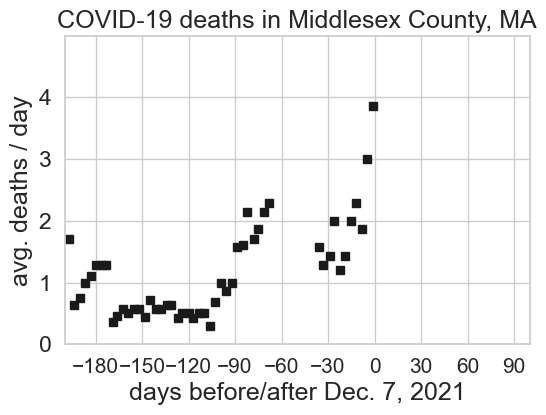

In [82]:
plt.subplots(nrows=1, ncols=1, figsize=(W, H));
plt.plot(x_train_N, y_train_N, 'ks');
plt.ylim([0, 4.99]);
plt.xlim([-200, 100]);
plt.xticks(np.arange(-180, 91, 30), fontsize=15);
plt.xlabel('days before/after Dec. 7, 2021');
plt.ylabel('avg. deaths / day');
plt.title('COVID-19 deaths in Middlesex County, MA');

## Problem 2a: Plots of posterior samples with SqExp kernel

We'll draw a vertical red line at $x'=20$, which a few later questions ask about.

In [83]:
G = 501
x_grid_G = np.linspace(-200, 150, G)

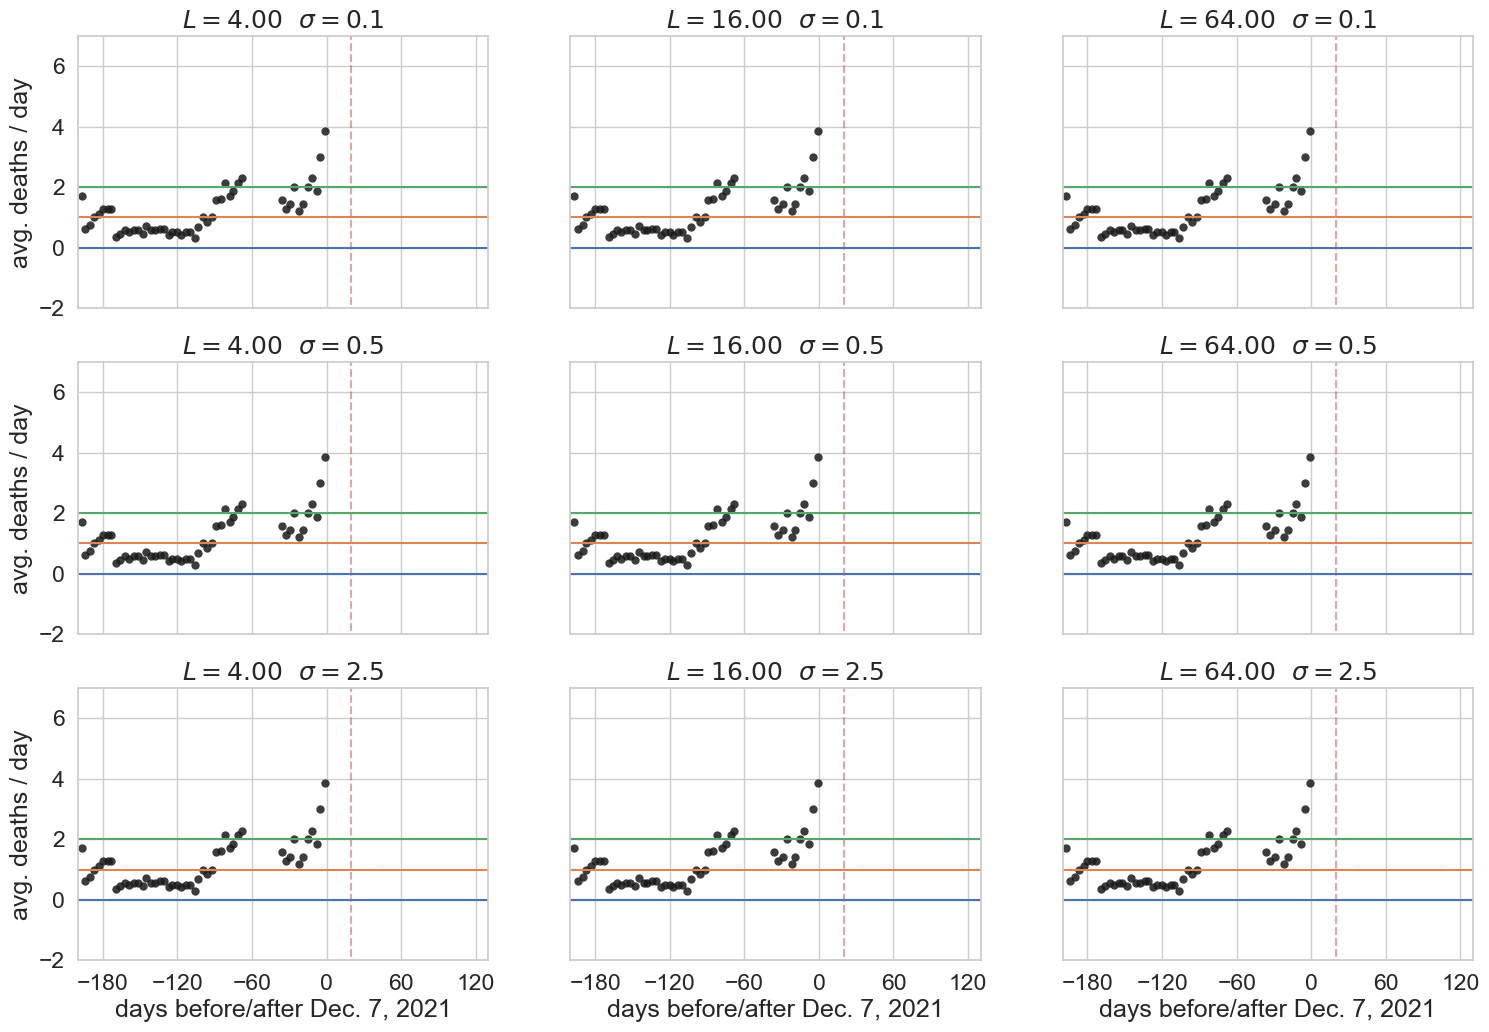

In [84]:
n_samples = 3

ell_list = [4.0, 16.0, 64.]
ncols = len(ell_list)

sigma_list = [0.1, 0.5, 2.5]
nrows = len(sigma_list)

fig_h, ax_grid_RC = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=True, sharey=True,
    figsize=(ncols * W, nrows * H)
)

for cc, L in enumerate(ell_list):
    for rr, sigma in enumerate(sigma_list):
        f_grid_SG = draw_sample_of_f_from_GP_posterior_at_x_grid(
            x_train_N, y_train_N,
            x_grid_G,
            mean_func, sqexp_kernel_func,
            sigma=sigma,
            kernel_kwargs=dict(L=L),
            n_samples=n_samples)

        # Show the training data as dark (but not too dark) dots
        cur_ax_h = ax_grid_RC[rr, cc]
        cur_ax_h.plot(
            x_train_N, y_train_N, 'k.',
            markersize=12, mew=0, alpha=0.85)

        # Show a vertical line at x=+20, which we'll ask about later
        x_20_H = [20, 20]
        y_20_H = [-3, 10]
        cur_ax_h.plot(
            x_20_H, y_20_H, 'r--', alpha=0.5)

        # Show the 3 samples from the posterior
        plot_f_samples_at_x_grid(
            x_grid_G,
            f_grid_SG,
            axis_handle=cur_ax_h
        )

        title_str = r'$L{=}%.2f~~\sigma{=}%.1f$' % (L, sigma)
        cur_ax_h.set_title(title_str)

        # Make the plot look pretty. Please don't adjust!
        cur_ax_h.set_ylim([-2, 6.99]);
        cur_ax_h.set_xlim([-200, 130]);
        cur_ax_h.set_xticks(np.arange(-180, 121, 60));
        if rr == 2:
            cur_ax_h.set_xlabel('days before/after Dec. 7, 2021');
        if cc == 0:
            cur_ax_h.set_ylabel('avg. deaths / day');

## Problem 2b: Provide the numerical values of the posterior mean/variance at f(20) for 3 settings

**Hint: We said we want the posterior mean of f, not y**

TODO

## Problem 2c: Provide a math formula for the 95% confidence interval of the posterior over y(20)

**Hint: We said y not f**

TODO you can write math like this:

$$
    (a + b, a - b)
$$

## Problem 2d: Comment on interpolation

**Q:** Fix $\sigma=0.1$ (the first row in your plot from 2a). What happens to the posterior samples of $f$ around $x=-50$ that differs across the largest and smallest choices of lengthscale $L$? Why?**

TODO

## Problem 2e: Comment on Near-term extrapolation

**Q:** Which of the parameter settings in the 3x3 panel plot from 2a seem to offer the best predictions for the near-term future of the next month or so (days x = 1, 2, .... 30)? Why?

TODO

## Problem 2f: Comment on Far Extrapolation

**Q:** What will be the posterior mean / variance of f(x) at x = +365, using $L=16$ and $\sigma=0.1$? Please make an argument that leans on conceptual intuition to explain why, do not only plug-and-chug with a formula.

TODO

## Problem 2g. How would you specify the GP prior so that the posterior mean for some points x' such that x' >> 365 was around 2 and the variance was around 4?

TODO write equations